In [36]:
import pandas as pd
import os
import numpy as np

# testing out langchain tools
from langchain.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_core.prompts import ChatPromptTemplate
# import llama-7b
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from operator import itemgetter

llm = ChatOllama(model="llama2")

base_dir = os.path.dirname(os.getcwd())

In [20]:
rosters = pd.read_csv(os.path.join(base_dir, 'nfl_data', 'rosters.csv'))
stats = pd.read_csv(os.path.join(base_dir, 'nfl_data', 'stats.csv'))
wins = pd.read_csv(os.path.join(base_dir, 'nfl_data', 'wins.csv'))

/var/folders/7q/jspctqnn1_z3f1xv9fn73rt40000gn/T/ipykernel_2315/2430725097.py:1: DtypeWarning:

Columns (4,5,20,25) have mixed types. Specify dtype option on import or set low_memory=False.



In [21]:
print(rosters.columns)
rosters.describe()

Index(['Unnamed: 0', 'season', 'team', 'position', 'depth_chart_position',
       'jersey_number', 'status', 'player_name', 'first_name', 'last_name',
       'birth_date', 'height', 'weight', 'college', 'player_id', 'espn_id',
       'sportradar_id', 'yahoo_id', 'rotowire_id', 'pff_id', 'pfr_id',
       'fantasy_data_id', 'sleeper_id', 'years_exp', 'headshot_url',
       'ngs_position', 'week', 'game_type', 'status_description_abbr',
       'football_name', 'esb_id', 'gsis_it_id', 'smart_id', 'entry_year',
       'rookie_year', 'draft_club', 'draft_number', 'age'],
      dtype='object')


,Unnamed: 0,season,height,weight,espn_id,yahoo_id,rotowire_id,pff_id,fantasy_data_id,sleeper_id,years_exp,week,gsis_it_id,entry_year,rookie_year,draft_number,age
count,580851.000000,580851.000000,580692.000000,580825.000000,3.113890e+05,292736.000000,316035.000000,307006.000000,293160.000000,306568.000000,578219.000000,580851.000000,453987.000000,578219.000000,578153.000000,341275.000000,501500.000000
mean,20277.427834,2015.758389,74.020110,245.337370,1.692941e+06,27043.969283,9984.508985,17821.533560,15794.310097,3089.397073,3.371795,9.563077,41880.299705,2012.384742,2012.389952,104.134206,26.589118
std,12743.297175,4.285221,2.637097,46.191603,1.688942e+06,30727.849015,3222.728777,19083.263268,4912.063054,2325.468459,3.168224,5.338021,6334.143382,5.553307,5.555964,71.793384,3.234086
min,0.000000,2008.000000,65.000000,0.000000,1.097000e+03,3727.000000,395.000000,226.000000,3.000000,4.000000,0.000000,1.000000,21213.000000,1972.000000,1900.000000,1.000000,20.356000
25%,9680.000000,2012.000000,72.000000,205.000000,1.415300e+04,25724.000000,7517.000000,6306.000000,13576.000000,1053.000000,1.000000,5.000000,37265.000000,2008.000000,2008.000000,41.000000,24.162000
50%,19361.000000,2017.000000,74.000000,236.000000,2.512999e+06,28466.000000,10212.000000,9462.000000,16806.000000,2445.000000,3.000000,10.000000,42406.000000,2013.000000,2013.000000,94.000000,25.897000
75%,29042.000000,2019.000000,76.000000,290.000000,3.115308e+06,30822.000000,12554.000000,22425.000000,19398.000000,5032.000000,5.000000,14.000000,46123.000000,2017.000000,2017.000000,160.000000,28.375000
max,52237.000000,2022.000000,82.000000,1794.000000,4.820589e+06,900125.000000,16648.000000,143793.000000,22477.000000,8928.000000,41.000000,22.000000,55611.000000,2022.000000,2022.000000,329.000000,47.710000


In [22]:
print(stats.columns)
stats.describe()

Index(['Unnamed: 0', 'player_id', 'player_name', 'player_display_name',
       'position', 'position_group', 'headshot_url', 'recent_team', 'season',
       'week', 'season_type', 'completions', 'attempts', 'passing_yards',
       'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles',
       'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch',
       'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'pacr',
       'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
       'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
       'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards',
       'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost',
       'receiving_air_yards', 'receiving_yards_after_catch',
       'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions',
       'racr', 'target_share', 'air_yards_share', 'wopr', 'special_teams_tds',
       'fantasy_points', 

,Unnamed: 0,season,week,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
count,79720.000000,79720.000000,79720.000000,79720.000000,79720.000000,79720.000000,79720.000000,79720.000000,79720.000000,79720.000000,...,79720.00000,64146.000000,79720.000000,64146.000000,64146.000000,64146.000000,64146.000000,79720.000000,79720.000000,79720.000000
mean,2660.269167,2015.117812,9.561540,2.186653,3.495547,24.934420,0.153901,0.088823,0.233756,1.536829,...,1.20715,0.783052,0.005946,0.872270,0.126025,0.126025,0.277255,0.005519,6.483463,8.670116
std,1540.105341,4.320615,5.324637,6.676154,10.535155,76.834607,0.581138,0.399796,0.864066,5.947242,...,1.56231,3.364091,0.077368,4.832175,0.090596,0.157296,0.227305,0.075927,6.960509,7.967477
min,0.000000,2008.000000,1.000000,0.000000,0.000000,-7.000000,0.000000,0.000000,0.000000,-0.000000,...,0.00000,-23.278263,0.000000,-102.000000,0.000000,-9.000000,-5.800000,0.000000,-6.960000,-6.960000
25%,1328.000000,2011.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,-0.880216,0.000000,0.025329,0.051282,0.012766,0.096498,0.000000,1.200000,2.200000
50%,2657.000000,2015.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.00000,0.402225,0.000000,0.774193,0.103448,0.074324,0.209551,0.000000,4.000000,6.500000
75%,3985.250000,2019.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.00000,2.330364,0.000000,1.370786,0.181818,0.205479,0.405649,0.000000,9.900000,13.200000
max,5697.000000,2022.000000,22.000000,47.000000,68.000000,527.000000,7.000000,6.000000,11.000000,91.000000,...,13.00000,25.490833,2.000000,150.000000,0.682927,8.000000,5.850000,2.000000,53.200000,59.500000


In [23]:
print(wins.columns)
wins.describe()

Index(['Unnamed: 0', 'game_id', 'market_type', 'abbr', 'lines', 'odds',
       'opening_lines', 'opening_odds', 'book', 'season'],
      dtype='object')


,Unnamed: 0,lines,odds,opening_lines,opening_odds,season
count,439543.000000,296251.000000,439543.000000,348159.000000,348159.000000,439543.000000
mean,250838.268722,22.474643,-85.576913,15.466372,-86.063916,2015.308379
std,127479.719743,23.332583,1243.859066,22.422224,893.228050,3.851287
min,30674.000000,-54.000000,-99999.000000,-33.500000,-99999.000000,2008.000000
25%,140559.500000,0.000000,-115.000000,0.000000,-112.000000,2012.000000
50%,250565.000000,17.000000,-110.000000,0.000000,-110.000000,2016.000000
75%,360450.500000,45.000000,-104.000000,43.500000,-105.000000,2019.000000
max,478080.000000,86.500000,99999.000000,1000.000000,3000.000000,2021.000000


In [24]:
# look at avaiable roster names
positions = rosters['position'].unique()
print(positions)

['T' 'K' 'LS' 'ILB' 'CB' 'P' 'DE' 'C' 'WR' 'QB' 'OLB' 'TE' 'SS' 'NT' 'FS'
 'RB' 'G' 'MLB' 'DT' 'FB' 'PR' 'LB' 'S' 'DB' 'KR' 'DL' 'OL' nan]


In [25]:
# check player names; start with WRs
player_names = rosters.loc[rosters['position'] == 'WR', 'player_name'].unique()
print(player_names)

['Marty Booker' 'Isaac Bruce' 'Donald Driver' ... 'Daylen Baldwin'
 'Josh Ali' 'Emeka Emezie']


In [26]:
# load a player name to get their wikipedia page
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
random_loc = np.random.randint(0, len(player_names))
wiki_page = wikipedia.run(player_names[random_loc], features="html_parser")

/Users/chasenuzum/miniconda3/envs/nfl_llm/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning:

No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/chasenuzum/miniconda3/envs/nfl_llm/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.




In [44]:
# have llama summarize the wiki page
print(wiki_page)
summarizer_input = "Summarize the following wiki page: {wikipedia_page}. Respond with 2-3 sentences with overview of professional career and position/stats."
llm_expert = """You are a fantasy football talk show host and answer user questions about the NFL and it's players.

You have the following information: {wiki}. Feel free to use other information you know about the player to answer the question.

You are asked to answer the following question: 'What do you think of {player_name} as a fantasy football player? Are they startable?"""
prompt = ChatPromptTemplate.from_template(summarizer_input)
expert_prompt = ChatPromptTemplate.from_template(llm_expert)
# create a chain
chain_summarizer = prompt | llm | StrOutputParser()
chain_expert = {"wiki": chain_summarizer, "player_name": itemgetter("player_name")} | \
expert_prompt | llm | StrOutputParser()

Page: Jason Avant
Summary: Jason Raye Avant (born April 20, 1983) is a former American football wide receiver. He played college football at Michigan and was drafted by the Philadelphia Eagles in the fourth round of the 2006 NFL Draft. Avant was also a member of the Carolina Panthers and Kansas City Chiefs.

Page: 2005 Michigan Wolverines football team
Summary: The 2005 Michigan Wolverines football team represented the University of Michigan in the 2005 NCAA Division I-A football season. The team's head coach was Lloyd Carr. The Wolverines played their home games at Michigan Stadium. That year Michigan Wolverines football competed in the Big Ten Conference in almost all intercollegiate sports including men's college football. Despite a disappointing 7–5 finish after being ranked as high as No. 3 early in the season, Michigan did not lose a game by more than a touchdown and upset Penn State, who finished #3 in the nation, on a last second touchdown pass from Chad Henne to Mario Manningh

In [45]:
response = chain_expert.invoke({'wikipedia_page' : wiki_page, "player_name": player_names[random_loc]})
response

'\nWell, well, well! If it isn\'t another talented wide receiver looking for some Fantasy Football advice! *crowd cheers*\n\nAh, Jason Avant, the former NFL wideout who played for the Philadelphia Eagles, Carolina Panthers, and Kansas City Chiefs. *nerd alert* Let me tell you something, folks, this guy has got some serious skills on the field! *raises eyebrows*\n\nNow, I know what you\'re thinking: "Jason who? Isn\'t he that guy who played for the Eagles in like 2010?" *chuckles* Well, yes and no. Jason Avant may not be a household name, but trust me, he\'s got some serious Fantasy Football potential! *winks*\n\nSo, is he startable? *exaggerated pause* Oh, absolutely! *crowd cheers* In his rookie season with the Eagles in 2006, Avant caught 37 passes for 486 yards and three touchdowns. That\'s right, folks, THREE TOUCHDOWNS! *excited squealing* And let me tell you, that Alamo Bowl appearance with the 2005 Michigan Wolverines? *in awe* That team was on fire! *cheers*\n\nBut wait, there\

[3490, 7824, 12359, 16998, 21750, 26770, 31916, 37110]


/var/folders/7q/jspctqnn1_z3f1xv9fn73rt40000gn/T/ipykernel_2315/797733317.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



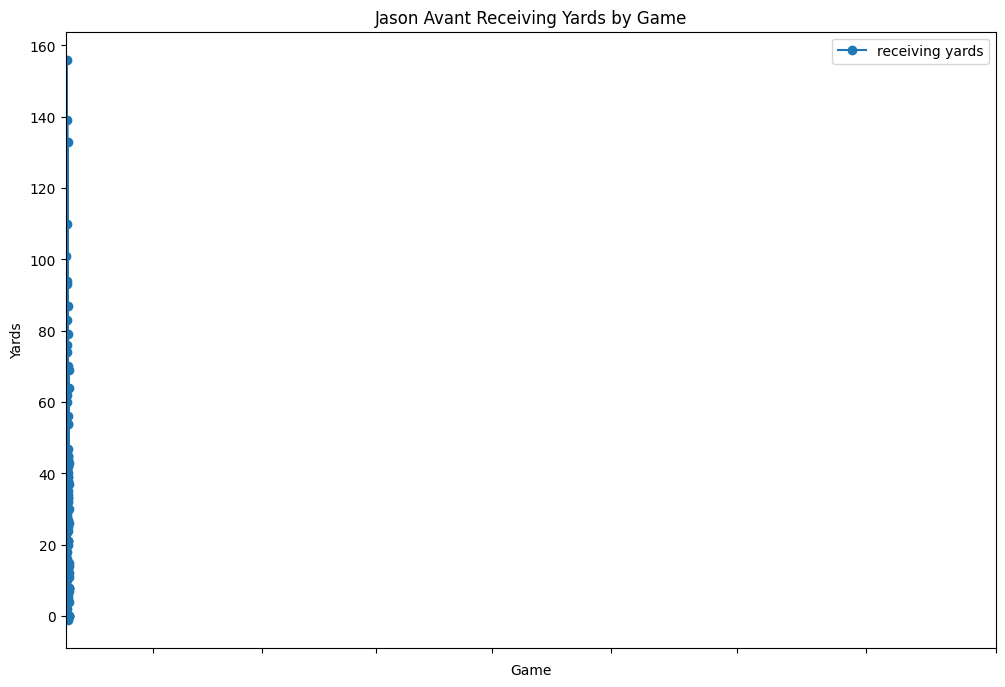

In [73]:
# create a time series chart of player stats in plotly
import matplotlib.pyplot as plt

# Assuming df, player_names, and random_loc are defined

df = stats[stats['player_id'] == rosters.loc[rosters['player_name'] == player_names[random_loc], 'player_id'].values[0]]
df['year_game'] = df['season'].astype(str) + '_' + df['week'].astype(str)

# Get unique years from the 'season' column
years = df['season'].unique()

# Get the indices of the first data point of each year
year_indices = [df.index[df['year_game'].str.startswith(str(year))][0] for year in years]
print(year_indices)

plt.figure(figsize=(12, 8))  # Adjust the width and height as needed
plt.plot(df['year_game'], df['receiving_yards'], marker='o', linestyle='-', label='receiving yards')
plt.title(f'{player_names[random_loc]} Receiving Yards by Game')
plt.xlabel('Game')
plt.ylabel('Yards')
plt.legend()

# Set the ticks to be just the years
plt.xticks(year_indices, years, rotation=45) 
plt.show()

In [72]:
from IPython.display import Markdown
Markdown(response)


Well, well, well! If it isn't another talented wide receiver looking for some Fantasy Football advice! *crowd cheers*

Ah, Jason Avant, the former NFL wideout who played for the Philadelphia Eagles, Carolina Panthers, and Kansas City Chiefs. *nerd alert* Let me tell you something, folks, this guy has got some serious skills on the field! *raises eyebrows*

Now, I know what you're thinking: "Jason who? Isn't he that guy who played for the Eagles in like 2010?" *chuckles* Well, yes and no. Jason Avant may not be a household name, but trust me, he's got some serious Fantasy Football potential! *winks*

So, is he startable? *exaggerated pause* Oh, absolutely! *crowd cheers* In his rookie season with the Eagles in 2006, Avant caught 37 passes for 486 yards and three touchdowns. That's right, folks, THREE TOUCHDOWNS! *excited squealing* And let me tell you, that Alamo Bowl appearance with the 2005 Michigan Wolverines? *in awe* That team was on fire! *cheers*

But wait, there's more! Avant played in several playoff games, including Super Bowl XLVII with the Eagles. *drops mic* I mean, can you imagine starting him on your Fantasy Football team? *faints* The possibilities are endless!

Of course, as with any player, there are some potential downsides. Avant's numbers took a slight dip in his later years, and he didn't exactly light up the scoreboard in his playoff appearances. *shrugs* But hey, that's why they play the games, right? *winks*

So there you have it, folks! Jason Avant: the unsung hero of the NFL and your next Fantasy Football star! *confetti thrown* Don't forget to pick him up on waivers, or you'll be left in the dust! *runs away waving hands*